In [2]:
import torch
import FISHPainter
import numpy as np
from FISHPainter.src.preprocess import get_cell_background
from FISHPainter.src.signals import create_FISH
from FISHPainter.src.process_boxes import merge_boxes_by_labels
from FISHPainter.src.utils import dataset_from_bboxes
from CellPatchExtraction import extract_patches

#debug
from cellplot.patches import gridPlot, draw_boxes_on_patch

FISHPainter.__version__

'0.5'

In [3]:
background = get_cell_background("/home/simon_g/src/FISHPainter_package/testdata/IF_RGB.TIFF", normalize=False)[:700, :700]
print(background.shape)

(700, 700, 3)


In [4]:
patches, masks, _, _, _ = extract_patches(background, "CP_TU", patch_size=128, return_all=True, device=torch.device("cuda:3"))
len(patches)

120

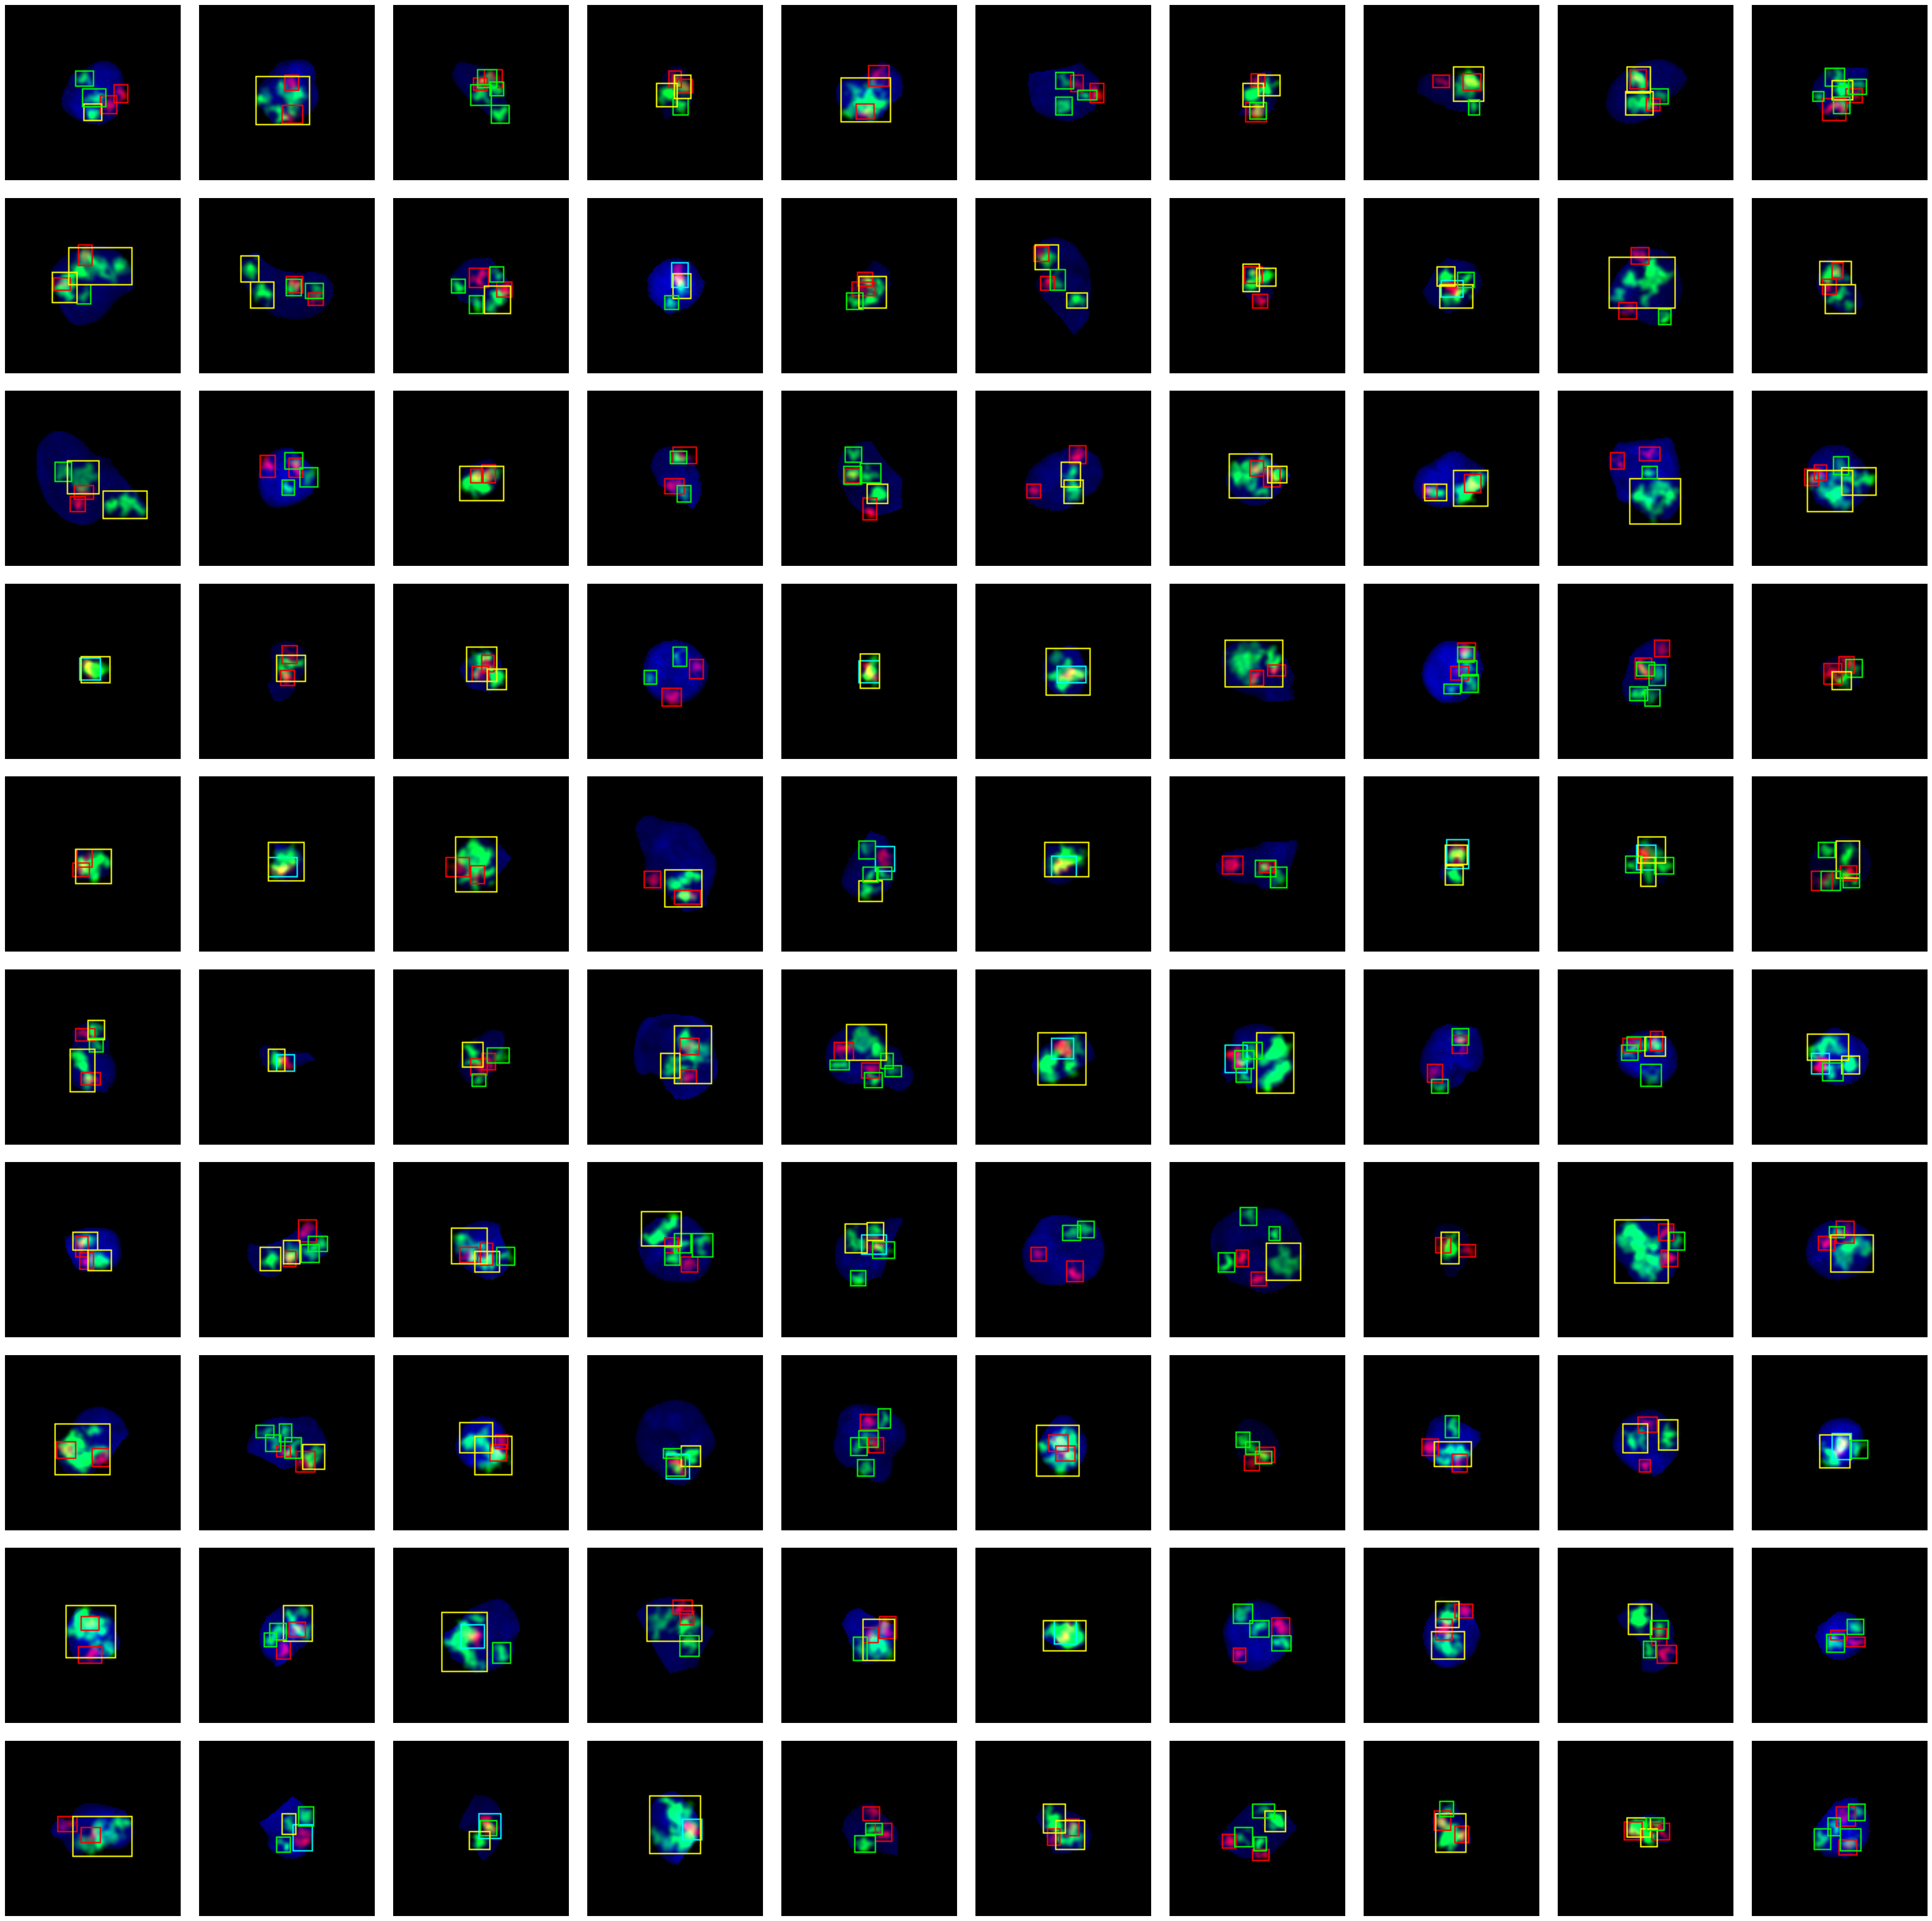

In [6]:
patches_with_boxes = []
bbox_dataset = []
for patch, mask in zip(patches, masks):
    n_green = np.random.randint(2, 8, 1)[0]
    n_green_cluster = np.random.choice([0, 1, 2, 3], p=[0.7, 0.15, 0.1, 0.05])
    FISH_dict = create_FISH(patch.copy(), mask.copy(), num_red=2, num_green=n_green, num_green_cluster=n_green_cluster, green_cluster_size=4, return_as_dict=True)
    bbox_img = draw_boxes_on_patch(FISH_dict["patch"].copy(), FISH_dict["bboxes"], FISH_dict["labels"])
    patches_with_boxes.append(bbox_img)
    bbox_dataset.append(FISH_dict)
    
gridPlot(patches_with_boxes, plot_size=(50,50))

#dataset_from_bboxes(bbox_dataset=bbox_dataset, filepath="/home/simon_g/src/FISHPainter/testdata/bbox_dataset.h5")

In [10]:
#create whole dataset
background = get_cell_background("/home/simon_g/src/FISHPainter_package/testdata/IF_RGB.TIFF", normalize=False)[:2000, :2000]

In [11]:
patches, masks, _, _, _ = extract_patches(background, "CP_TU", patch_size=128, return_all=True, device=torch.device("cuda:3"))
len(patches)

1233

In [17]:
created = []
while True:
    for patch, mask in zip(patches, masks):
        n_green = np.random.randint(2, 10, 1)[0]
        n_green_cluster = np.random.choice([0, 1, 2, 3], p=[0.5, 0.25, 0.15, 0.1])
        signal_size = np.random.uniform(1.5, 2.5)
        FISH_dict = create_FISH(patch.copy(), mask.copy(), num_red=2, num_green=n_green, num_green_cluster=n_green_cluster, signal_size=signal_size, return_as_dict=True)
        created.append(FISH_dict)
        
        if len(created) > 5000:
            break
        
    if len(created) > 5000:
        break

In [18]:
dataset_from_bboxes(bbox_dataset=created, filepath="/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/_simon/data/datasets/bbox_dataset.h5")

In [ ]:
import matplotlib.pyplot as plt

background = np.zeros((128, 128, 3))
background[30:100, 40:90, 2] = 1

plt.imshow(background)

image, bboxes, labels = create_FISH(background, mask=background[..., 2], num_red=2, num_green=2, num_red_cluster=2, num_green_cluster=2, signal_size=2)
plt.imshow(draw_boxes_on_patch(image, bboxes, labels))